In [3]:
"""
Hyperspectral Analysis Pipeline
Complete workflow for fiducial detection, circle detection, homography, and reflectance analysis
Author: Khang Tran
Date: October 2025
"""

import numpy as np
import matplotlib.pyplot as plt
import os

# Import our custom libraries
from modules import SpectralDataLoader, FeatureDetector, ImageRegistration, ReflectanceAnalyzer

# Configure matplotlib for inline plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [6]:
# Data paths and settings
BASE_PATH = "/Users/khangtran/Documents/Programming/Schools/COSI/Defect_Search/IDP Group C"
SAMPLE_NAME = "Defect1"  # Change this to analyze different samples

ANALYSIS_WAVELENGTH = 700  # Wavelength for fiducial/circle detection (nm)
RESULTS_DIR = "results/jupyter_analysis"

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)

# Analysis parameters
CIRCLE_CROP_REGION = (0.075, 0.5, 0.0, 0.5)

In [7]:
# STEP 1: DATA LOADING

# Initialize data loader
loader = SpectralDataLoader(BASE_PATH)
datasets = loader.load_all_datasets(SAMPLE_NAME)

if datasets is None:
    print("❌ Failed to load datasets. Exiting.")
    exit(1)

# Extract individual cubes for convenience
reference_cube = datasets['reference']
sample_cube = datasets[SAMPLE_NAME]
white_cube = datasets['white']
dark_cube = datasets['Darkreference']

print(f"\nDataset Summary:")
print(f"   Reference: {reference_cube.shape}")
print(f"   Sample ({SAMPLE_NAME}): {sample_cube.shape}")
print(f"   White: {white_cube.shape}")
print(f"   Dark: {dark_cube.shape}")

# Get analysis wavelength bands
ref_band, band_idx = loader.get_wavelength_band(reference_cube, ANALYSIS_WAVELENGTH)
sample_band, _ = loader.get_wavelength_band(sample_cube, ANALYSIS_WAVELENGTH)

if ref_band is None:
    print(f"❌ Wavelength {ANALYSIS_WAVELENGTH}nm not available")
    exit(1)

print(f"Using band {band_idx} for {ANALYSIS_WAVELENGTH}nm analysis")

📁 Loading reference spectral cube...
✅ Loaded reference: (1040, 1392, 51)
📁 Loading white spectral cube...
✅ Loaded white: (1040, 1392, 51)
📁 Loading Darkreference spectral cube...
✅ Loaded Darkreference: (1040, 1392, 51)
📁 Loading Defect1 spectral cube...
✅ Loaded Defect1: (1040, 1392, 51)
✅ All datasets loaded successfully

Dataset Summary:
   Reference: (1040, 1392, 51)
   Sample (Defect1): (1040, 1392, 51)
   White: (1040, 1392, 51)
   Dark: (1040, 1392, 51)
Using band 25 for 700nm analysis


🎯 Detecting 4 fiducials...
   Found 4 initial candidates
   4/4 passed cross-shape threshold
   ✅ Selected 4 fiducials
🎯 Detecting 4 fiducials...
   Found 5 initial candidates
   5/5 passed cross-shape threshold
   ✅ Selected 4 fiducials

Fiducial Detection Results:
   Reference fiducials: [(874, 150), (270, 301), (385, 702), (1341, 943)]
   Sample fiducials: [(870, 152), (267, 301), (380, 705), (1338, 945)]


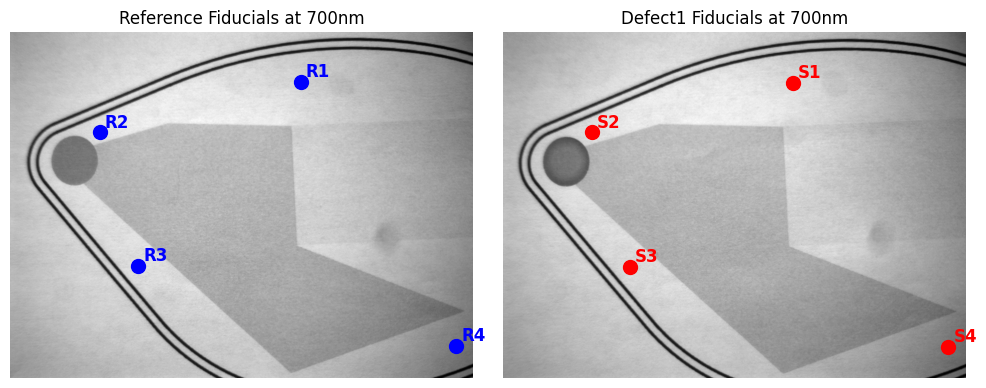

In [14]:
# STEP 2: DETECT FIDUCIAL POINTS

# Initialize feature detector
detector = FeatureDetector()

# Detect fiducials in reference image
reference_fiducials = detector.detect_fiducials(ref_band, num_fiducials=4)

# Detect fiducials in sample image
sample_fiducials = detector.detect_fiducials(sample_band, num_fiducials=4)

print(f"\nFiducial Detection Results:")
print(f"   Reference fiducials: {reference_fiducials}")
print(f"   Sample fiducials: {sample_fiducials}")

# Visualize fiducial detection
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

# Reference with fiducials
ax1.imshow(ref_band, cmap='gray')
for i, (x, y) in enumerate(reference_fiducials):
    ax1.plot(x, y, 'bo', markersize=10)
    ax1.text(x+15, y-15, f'R{i+1}', color='blue', fontsize=12, fontweight='bold')
ax1.set_title(f'Reference Fiducials at {ANALYSIS_WAVELENGTH}nm')
ax1.axis('off')

# Sample with fiducials
ax2.imshow(sample_band, cmap='gray')
for i, (x, y) in enumerate(sample_fiducials):
    ax2.plot(x, y, 'ro', markersize=10)
    ax2.text(x+15, y-15, f'S{i+1}', color='red', fontsize=12, fontweight='bold')
ax2.set_title(f'{SAMPLE_NAME} Fiducials at {ANALYSIS_WAVELENGTH}nm')
ax2.axis('off')

plt.tight_layout()
# plt.savefig(f'{RESULTS_DIR}/fiducial_detection.png', bbox_inches='tight')
plt.show()

🎯 Detecting circular features...
✅ Found 1 circle candidates
  Circle at (90,382) radius 70: score 0.545
✅ Best circle: center (np.int64(197), np.int64(385)), radius 73

IC Circle Detection Results:
   Center: (np.int64(197), np.int64(385))
   Radius: 73
   Score: 0.545


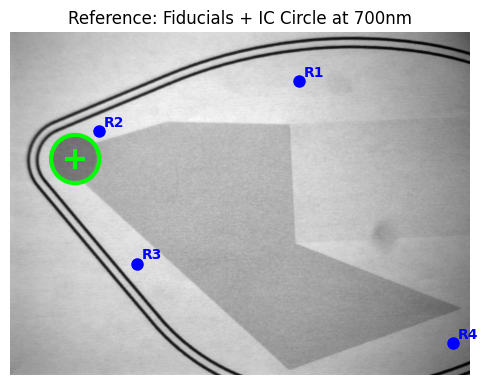

In [13]:
# STEP 3: DETECT IC CIRCLE IN REFERENCE

# Detect IC circle in reference (top-left region)
ic_circle = detector.detect_circle(ref_band, crop_region=CIRCLE_CROP_REGION)

if ic_circle is None:
    print("❌ Failed to detect IC circle")
    exit(1)
else:
    print(f"\nIC Circle Detection Results:")
    print(f"   Center: {ic_circle['center']}")
    print(f"   Radius: {ic_circle['radius']}")
    print(f"   Score: {ic_circle['score']:.3f}")

# Visualize circle detection
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.imshow(ref_band, cmap='gray')

# Draw fiducials
for i, (x, y) in enumerate(reference_fiducials):
    ax.plot(x, y, 'bo', markersize=8)
    ax.text(x+15, y-15, f'R{i+1}', color='blue', fontsize=10, fontweight='bold')

# Draw IC circle
center = ic_circle['center']
radius = ic_circle['radius']
circle = plt.Circle(center, radius, fill=False, color='lime', linewidth=3)
ax.add_patch(circle)
ax.plot(center[0], center[1], '+', color='lime', markersize=15, markeredgewidth=3)

ax.set_title(f'Reference: Fiducials + IC Circle at {ANALYSIS_WAVELENGTH}nm')
ax.axis('off')

plt.tight_layout()
# plt.savefig(f'{RESULTS_DIR}/circle_detection.png', bbox_inches='tight')
plt.show()

🔄 Computing homography matrix...
✅ Homography computed
   Mean reprojection error: 0.00 pixels
   Individual errors: ['0.00', '0.00', '0.00', '0.00']

Registration Quality: Excellent

Registering sample cube...
🔄 Registering spectral cube...
   Processing 51 wavelength bands...
   Band 1/51
   Band 11/51
   Band 21/51
   Band 31/51
   Band 41/51
   Band 51/51
✅ Cube registration complete


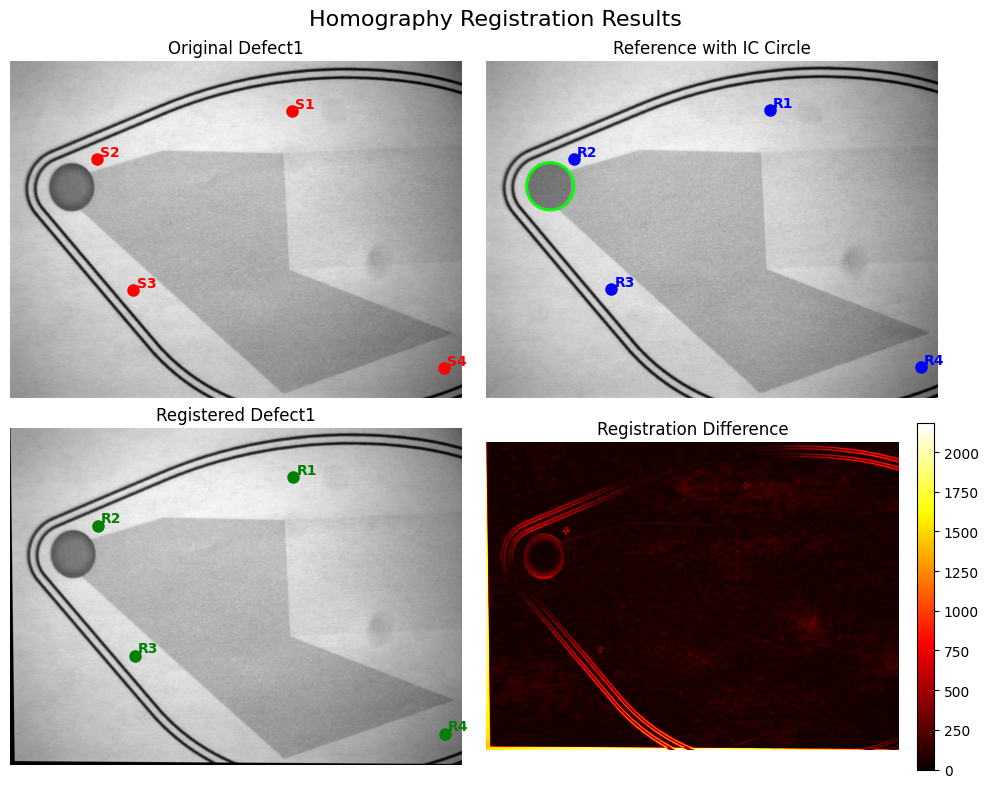

In [17]:
# STEP 4: COMPUTE HOMOGRAPHY AND REGISTER SAMPLE

# Initialize image registration adn compute homography matrix
registrator = ImageRegistration()
homography_matrix = registrator.compute_homography(sample_fiducials, reference_fiducials)

# Get registration quality
quality_metrics = registrator.get_registration_quality()
print(f"\nRegistration Quality: {quality_metrics['quality']}")

# Register the sample cube
print(f"\nRegistering sample cube...")
registered_sample_cube = registrator.register_cube(sample_cube, homography_matrix)


# Visualize registration results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Original sample
ax1.imshow(sample_band, cmap='gray')
for i, (x, y) in enumerate(sample_fiducials):
    ax1.plot(x, y, 'ro', markersize=8)
    ax1.text(x+10, y-10, f'S{i+1}', color='red', fontweight='bold')
ax1.set_title(f'Original {SAMPLE_NAME}')
ax1.axis('off')

# Reference
ax2.imshow(ref_band, cmap='gray')
for i, (x, y) in enumerate(reference_fiducials):
    ax2.plot(x, y, 'bo', markersize=8)
    ax2.text(x+10, y-10, f'R{i+1}', color='blue', fontweight='bold')

# Add IC circle
circle = plt.Circle(center, radius, fill=False, color='lime', linewidth=2)
ax2.add_patch(circle)
ax2.set_title('Reference with IC Circle')
ax2.axis('off')

# Registered sample
registered_band = registered_sample_cube[:, :, band_idx]
ax3.imshow(registered_band, cmap='gray')
# Show where fiducials should now be (reference positions)
for i, (x, y) in enumerate(reference_fiducials):
    ax3.plot(x, y, 'go', markersize=8)
    ax3.text(x+10, y-10, f'R{i+1}', color='green', fontweight='bold')
ax3.set_title(f'Registered {SAMPLE_NAME}')
ax3.axis('off')

# Registration difference
diff = np.abs(ref_band.astype(np.float32) - registered_band.astype(np.float32))
im = ax4.imshow(diff, cmap='hot')
ax4.set_title('Registration Difference')
ax4.axis('off')
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

plt.suptitle(f'Homography Registration Results', fontsize=16)
plt.tight_layout()
# plt.savefig(f'{RESULTS_DIR}/homography_registration.png', bbox_inches='tight')
plt.show()


🎯 Creating IC ROI mask...
🎯 Creating circular ROI mask...
✅ ROI mask created:
   Center: (np.int64(197), np.int64(385)), Radius: 73
   ROI pixels: 16,729 (1.16% coverage)


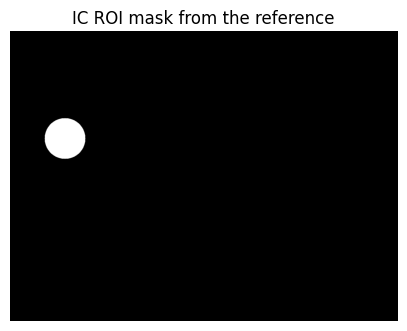


🔬 Computing reference reflectance...
🔬 Computing reflectance...
   Processing 51 wavelength bands...
   Band 1/51
   Band 11/51
   Band 21/51
   Band 31/51
   Band 41/51
   Band 51/51
✅ Reflectance computation complete

🔬 Computing sample reflectance...
🔬 Computing reflectance...
   Processing 51 wavelength bands...
   Band 1/51
   Band 11/51
   Band 21/51
   Band 31/51
   Band 41/51
   Band 51/51
✅ Reflectance computation complete

📊 Extracting ROI reflectance spectra...
📊 Extracting ROI reflectance spectrum...
✅ ROI spectrum extracted:
   ROI pixels: 16,729
   Mean reflectance: 0.6209
   Std deviation: 0.0293
   SNR: 21.2
📊 Extracting ROI reflectance spectrum...
✅ ROI spectrum extracted:
   ROI pixels: 16,729
   Mean reflectance: 0.5923
   Std deviation: 0.0480
   SNR: 12.3
📊 Comparing reference vs sample ROI spectra...
✅ Spectral comparison complete:
   Mean difference: -0.0286
   Relative change: -5.23%
   Max difference at 470nm: 0.0441


In [20]:
# STEP 5: CREATE IC ROI MASK AND COMPUTE REFLECTANCE

# Create ROI mask from IC circle
print(f"\n🎯 Creating IC ROI mask...")
roi_mask = registrator.create_roi_mask(ref_band.shape, ic_circle)

# Visualize ROI mask
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.imshow(roi_mask, cmap='gray')
ax.set_title(f'IC ROI mask from the reference')
ax.axis('off')
plt.show()

# Initialize reflectance analyzer
analyzer = ReflectanceAnalyzer()

# Compute reflectance for reference
print(f"\n🔬 Computing reference reflectance...")
reference_reflectance = analyzer.compute_reflectance(reference_cube, white_cube, dark_cube)

# Compute reflectance for registered sample
print(f"\n🔬 Computing sample reflectance...")
sample_reflectance = analyzer.compute_reflectance(registered_sample_cube, white_cube, dark_cube)

# Extract ROI spectra
print(f"\n📊 Extracting ROI reflectance spectra...")
reference_roi_results = analyzer.extract_roi_spectrum(reference_reflectance, roi_mask)
sample_roi_results = analyzer.extract_roi_spectrum(sample_reflectance, roi_mask)

# Compare spectra
comparison_results = analyzer.compare_roi_spectra(reference_roi_results, sample_roi_results)

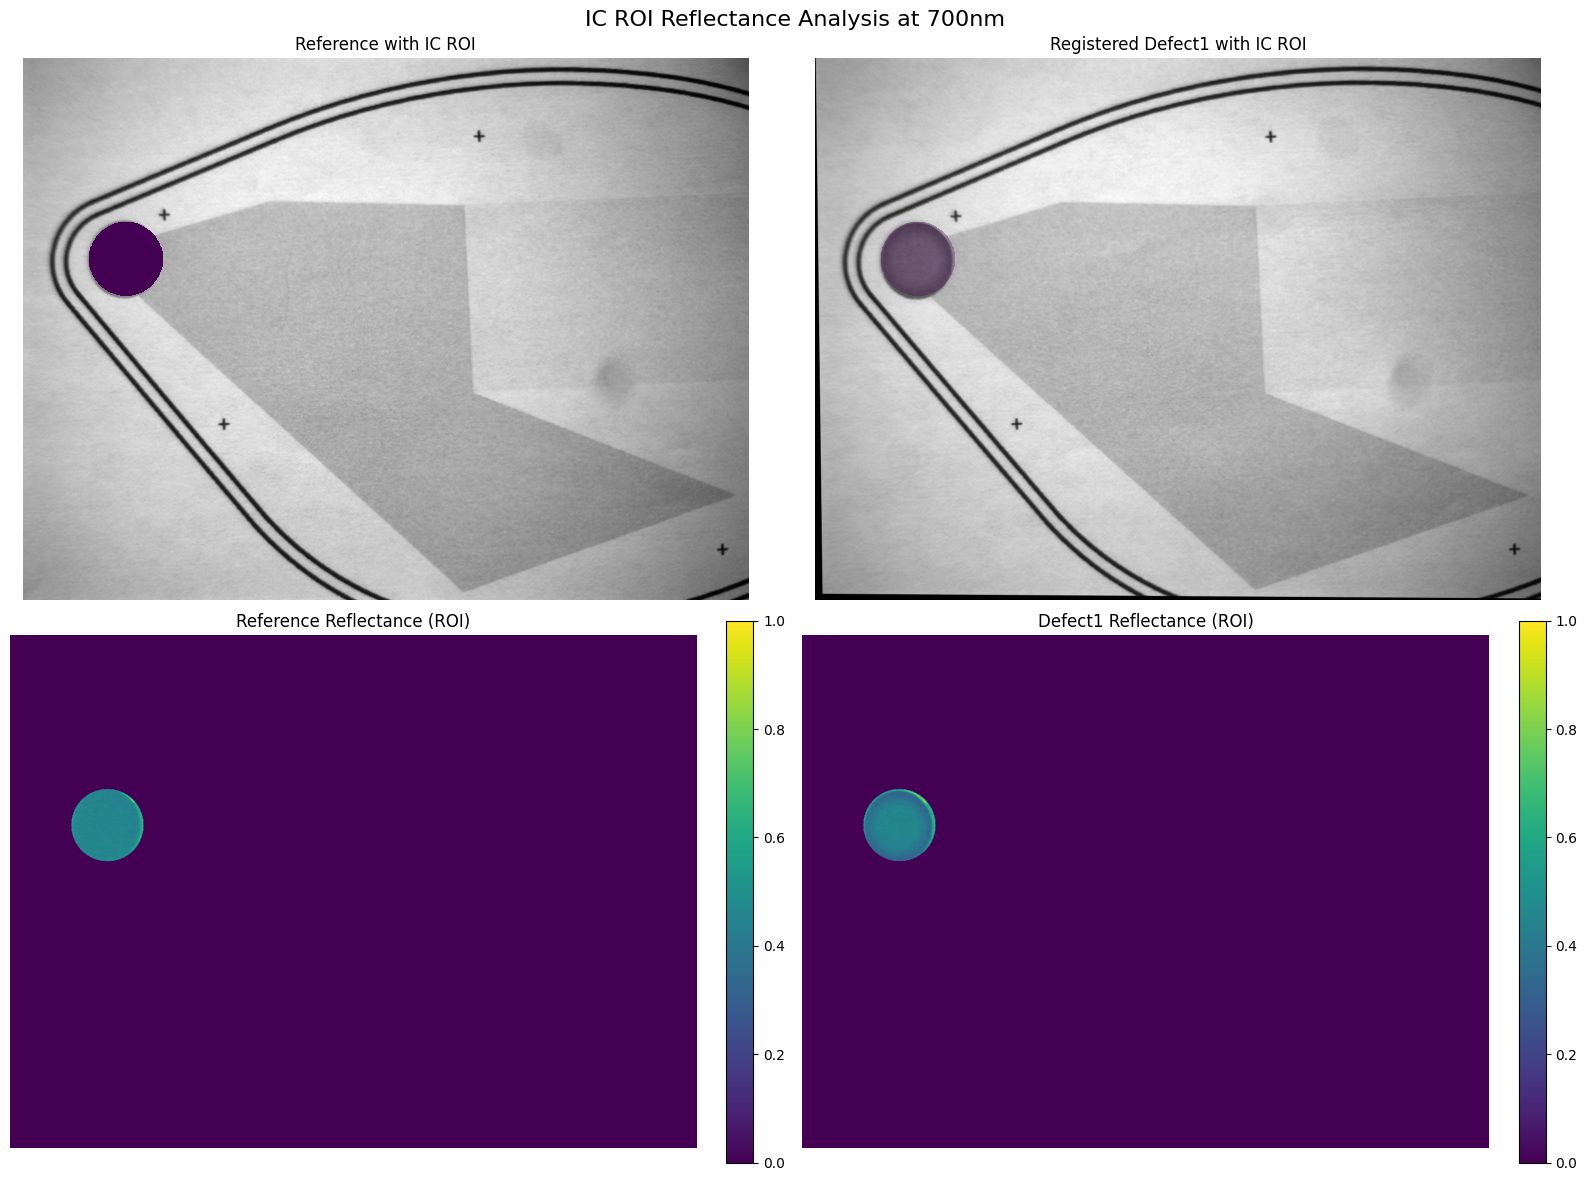

In [25]:
# STEP 6: VISUALIZATION AND RESULTS

# Plot ROI mask visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Reference with ROI
ax1.imshow(ref_band, cmap='gray')
roi_overlay = np.ma.masked_where(roi_mask == 0, roi_mask)
ax1.imshow(roi_overlay, cmap='viridis', alpha=1)
ax1.set_title('Reference with IC ROI')
ax1.axis('off')

# Registered sample with ROI
ax2.imshow(registered_band, cmap='gray')
ax2.imshow(roi_overlay, cmap='viridis', alpha=0.3)
ax2.set_title(f'Registered {SAMPLE_NAME} with IC ROI')
ax2.axis('off')

# Reference reflectance (ROI only)
ref_refl_band = reference_reflectance[:, :, band_idx]
ref_display = np.zeros_like(ref_refl_band)
ref_display[roi_mask > 0] = ref_refl_band[roi_mask > 0]
im3 = ax3.imshow(ref_display, cmap='viridis', vmin=0, vmax=1)
ax3.set_title('Reference Reflectance (ROI)')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

# Sample reflectance (ROI only)
sample_refl_band = sample_reflectance[:, :, band_idx]
sample_display = np.zeros_like(sample_refl_band)
sample_display[roi_mask > 0] = sample_refl_band[roi_mask > 0]
im4 = ax4.imshow(sample_display, cmap='viridis', vmin=0, vmax=1)
ax4.set_title(f'{SAMPLE_NAME} Reflectance (ROI)')
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

plt.suptitle(f'IC ROI Reflectance Analysis at {ANALYSIS_WAVELENGTH}nm', fontsize=16)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/04_reflectance_roi.png', bbox_inches='tight')
plt.show()